# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2

In [4]:
# Show df_content to get an idea of the data
df_content.head()

doc_body  \
0  Skip navigation Sign in SearchLoading...\r\n\r...   
1  No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2  ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3  DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4  Skip navigation Sign in SearchLoading...\r\n\r...   

                                     doc_description  \
0  Detect bad readings in real time using Python ...   
1  See the forest, see the trees. Here lies the c...   
2  Here’s this week’s news in Data Science and Bi...   
3  Learn how distributed DBs solve the problem of...   
4  This video demonstrates the power of IBM DataS...   

                                       doc_full_name doc_status  article_id  
0  Detect Malfunctioning IoT Sensors with Streami...       Live           0  
1  Communicating data science: A guide to present...       Live           1  
2         This Week in Data Science (April 18, 2017)       Live           2  
3  DataLayer Conference: Boost the performance of...       Live           3  
4      Analyze NY Restaurant data using Spark in DSX       Live           4

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
# Get some more content of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [7]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


Some data of `email` in the `df` dataframe appears to be missing. Same applies to `doc_body` and `doc_description` in `df_content`. `article_id` seems to be the key field between the two tables, where `df` is the data table and `df_content` probably the lookup table.

In [9]:
# Check missing emails in df
df[df['email'].isnull()]

article_id                                              title email
25131      1016.0  why you should master r (even if it might even...   NaN
29758      1393.0                       the nurse assignment problem   NaN
29759        20.0  working interactively with rstudio and noteboo...   NaN
29760      1174.0      breast cancer wisconsin (diagnostic) data set   NaN
29761        62.0  data visualization: the importance of excludin...   NaN
35264       224.0                   using apply, sapply, lapply in r   NaN
35276       961.0                     beyond parallelize and collect   NaN
35277       268.0                      sector correlations shiny app   NaN
35278       268.0                      sector correlations shiny app   NaN
35279       268.0                      sector correlations shiny app   NaN
35280       268.0                      sector correlations shiny app   NaN
35281       415.0  using machine learning to predict value of hom...   NaN
35282       846.0        pearson correlation aggregation on sparksql   NaN
35283       268.0                      sector correlations shiny app   NaN
35284       162.0  an introduction to stock market data analysis ...   NaN
42749       647.0                 getting started with apache mahout   NaN
42750       965.0  data visualization playbook: revisiting the ba...   NaN

In [10]:
# Check missing doc_body in df_content
df_content[df_content['doc_body'].isnull()]

doc_body                                    doc_description  \
206       NaN  Watch how to convert XML data to CSV format to...   
276       NaN  Love to work in Microsoft Excel? Watch how to ...   
484       NaN  See how to evaluate and convert your DDL and S...   
508       NaN  Watch how to generate SQL-based reports for Cl...   
540       NaN  Need to move some data to the cloud for wareho...   
638       NaN  See how to create a new dashDB instance and po...   
667       NaN  See how to connect dashDB, as a source and tar...   
706       NaN  Aginity Workbench is a free application known ...   
842       NaN  Learn how to configure a dashDB connection in ...   
876       NaN  See how to populate data into a table in your ...   
889       NaN  Watch how to apply association rules using R t...   
947       NaN  Watch how to extract and export dashDB data to...   
1037      NaN  See how quick and easy it is to set up a dashD...   
1054      NaN  Learn how to use IBM dashDB as data store for ...   

                                          doc_full_name doc_status  article_id  
206                           Load XML data into dashDB       Live         206  
276                         Integrate dashDB with Excel       Live         276  
484        Convert IBM Puredata for Analytics to dashDB       Live         483  
508    Use dashDB with IBM Embeddable Reporting Service       Live         507  
540                  Convert data from Oracle to dashDB       Live         539  
638        Load JSON from Cloudant database into dashDB       Live         637  
667              Integrate dashDB and Informatica Cloud       Live         666  
706                Use Aginity Workbench for IBM dashDB       Live         704  
842     Leverage dashDB in Cognos Business Intelligence       Live         839  
876              Load data from the desktop into dashDB       Live         873  
889   Perform market basket analysis using dashDB and R       Live         886  
947        Extract and export dashDB data to a CSV file       Live         944  
1037                 Get started with dashDB on Bluemix       Live        1032  
1054                              Use dashDB with Spark       Live        1049

In [11]:
# Check missing doc_body in df_content
df_content[df_content['doc_description'].isnull()]

doc_body doc_description  \
354  The search index lets you create flexible quer...             NaN   
768  Compose The Compose logo Articles Sign in Free...             NaN   
919  Cloudant Query is a powerful declarative JSON ...             NaN   

                                  doc_full_name doc_status  article_id  
354          Build the search index in Cloudant       Live         354  
768  Announcing the Data Browser for JanusGraph       Live         765  
919                  Use the new Cloudant query       Live         916

**During the exploratory data analysis it needs to be evaluated if and how to deal with these missing values.**

In [12]:
# How many unique article IDs are in df?
df.article_id.nunique()

714

In [13]:
# Are there duplicate article_ids in df_content?
df_content.article_id.nunique()

1051

In [14]:
df_content.article_id.value_counts().head(10)

221    2
232    2
577    2
398    2
50     2
356    1
355    1
354    1
353    1
345    1
Name: article_id, dtype: int64

**5 articles are duplicated. It must be assumed that the article_id must be a unique identifier. Trying to delete if "completely" duplicates:**

In [15]:
df_content.drop_duplicates(inplace=True)
df_content.article_id.value_counts().head(10)

221    2
232    2
577    2
398    2
50     2
356    1
355    1
354    1
353    1
345    1
Name: article_id, dtype: int64

**This didn't help. Apparently, there is some difference. Check what articles these are:**

In [17]:
df_content[(df_content.article_id.isin([
    221,
    232,
    577,
    398,
    50
]))].sort_values('article_id')

doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
365  Follow Sign in / Sign up Home About Insight Da...   
221  * United States\r\n\r\nIBM® * Site map\r\n\r\n...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
232  Homepage Follow Sign in Get started Homepage *...   
971  Homepage Follow Sign in Get started * Home\r\n...   
399  Homepage Follow Sign in Get started * Home\r\n...   
761  Homepage Follow Sign in Get started Homepage *...   
578  This video shows you how to construct queries ...   
970  This video shows you how to construct queries ...   

                                       doc_description  \
50                        Community Detection at Scale   
365  During the seven-week Insight Data Engineering...   
221  When used to make sense of huge amounts of con...   
692  One of the earliest documented catalogs was co...   
232  If you are like most data scientists, you are ...   
971  If you are like most data scientists, you are ...   
399  Today’s world of data science leverages data f...   
761  Today’s world of data science leverages data f...   
578  This video shows you how to construct queries ...   
970  This video shows you how to construct queries ...   

                                         doc_full_name doc_status  article_id  
50                        Graph-based machine learning       Live          50  
365                       Graph-based machine learning       Live          50  
221  How smart catalogs can turn the big data flood...       Live         221  
692  How smart catalogs can turn the big data flood...       Live         221  
232  Self-service data preparation with IBM Data Re...       Live         232  
971  Self-service data preparation with IBM Data Re...       Live         232  
399  Using Apache Spark as a parallel processing fr...       Live         398  
761  Using Apache Spark as a parallel processing fr...       Live         398  
578                              Use the Primary Index       Live         577  
970                              Use the Primary Index       Live         577

In [18]:
# These article_ids were used in df?
df[(df.article_id.isin([
    221,
    232,
    577,
    398,
    50
]))].groupby('article_id').count()

title  email
article_id              
50.0           89     89
221.0         113    113
232.0          68     68
398.0          21     21

In [19]:
# We need to remove the duplicates in df_content
#Because we don't known which record is correct we simply keep the first record. This is OK because of the small amount.
df_content = df_content.groupby('article_id').first().reset_index()

In [20]:
df_content[(df_content.article_id.isin([
    221,
    232,
    577,
    398,
    50
]))].sort_values('article_id')

article_id                                           doc_body  \
50           50  Follow Sign in / Sign up Home About Insight Da...   
221         221  * United States\r\n\r\nIBM® * Site map\r\n\r\n...   
232         232  Homepage Follow Sign in Get started Homepage *...   
398         398  Homepage Follow Sign in Get started * Home\r\n...   
577         577  This video shows you how to construct queries ...   

                                       doc_description  \
50                        Community Detection at Scale   
221  When used to make sense of huge amounts of con...   
232  If you are like most data scientists, you are ...   
398  Today’s world of data science leverages data f...   
577  This video shows you how to construct queries ...   

                                         doc_full_name doc_status  
50                        Graph-based machine learning       Live  
221  How smart catalogs can turn the big data flood...       Live  
232  Self-service data preparation with IBM Data Re...       Live  
398  Using Apache Spark as a parallel processing fr...       Live  
577                              Use the Primary Index       Live

Duplicates removed.

---
### User interactions
How many interactions are done by users?
I assume that a user is represented by an email and is not using two different email adressed.

<AxesSubplot:ylabel='Frequency'>

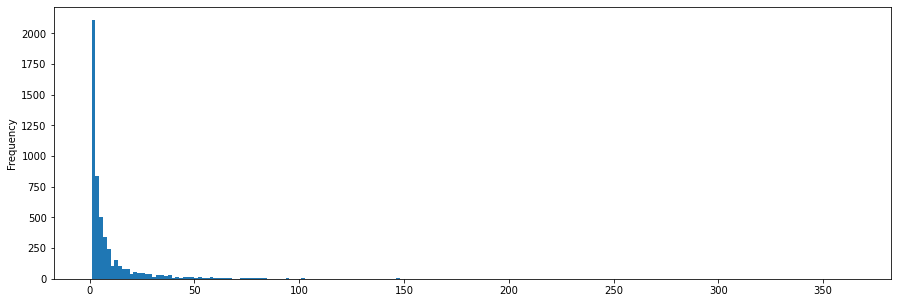

In [21]:
df['email'].value_counts().plot(kind='hist', figsize=(15,5), bins=200)

<AxesSubplot:>

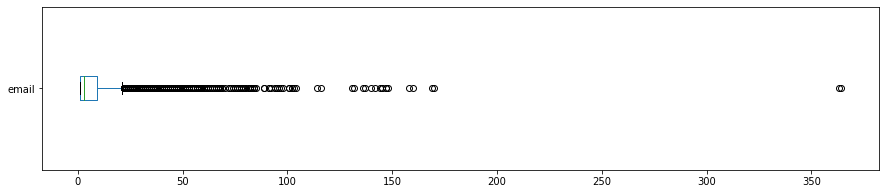

In [22]:
df['email'].value_counts().plot(kind='box', vert=False, figsize=(15,3))

In [23]:
df['email'].value_counts().mean()

8.930846930846931

<AxesSubplot:ylabel='Frequency'>

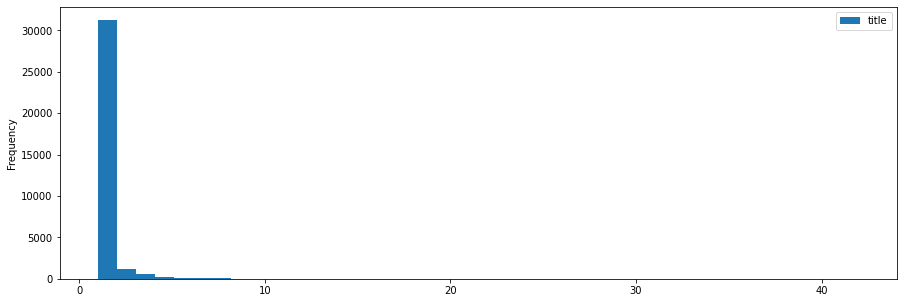

In [24]:
# Histogram of the user interaction with distinct articles
df.groupby([
    'email',
    'article_id'
]).count().sort_values(
    'title',
    ascending=False
).plot(
    kind='hist',
    figsize=(15,5),
    bins=40
)

<AxesSubplot:>

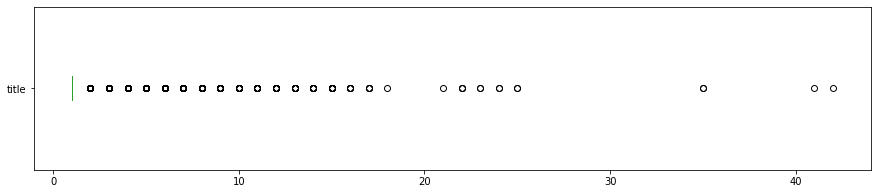

In [25]:
df.groupby([
    'email',
    'article_id'
]).count().sort_values(
    'title',
    ascending=False
).plot(
    kind='box',
    vert=False,
    figsize=(15,3)
)

In [26]:
#Average interation of a user with a distict article
df.groupby(['email','article_id']).count().mean()

title    1.365529
dtype: float64

A user interacts with a distinct article in average 1.37 times. The disctribution showa that the big mojority of users only interact on time with an article. There are a few outliers where users interact over 40 times.

In [27]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby(['email']).count().median()[0] # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby(['email']).count().max()[0] # The maximum number of user-article interactions by any 1 user is ______.

In [28]:
# Median interactions
median_val

3.0

In [29]:
# Maximum interactions
max_views_by_user

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [31]:
len(df)

45993

In [32]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051  # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [33]:
# Top 10 articles, sorted by interactions
df.groupby('article_id').count().sort_values('email', ascending=False).head()

title  email
article_id              
1429.0        937    937
1330.0        927    927
1431.0        671    671
1427.0        643    643
1364.0        627    627

In [34]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [35]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

article_id                                              title  user_id
0      1430.0  using pixiedust for fast, flexible, and easier...        1
1      1314.0       healthcare python streaming application demo        2
2      1429.0         use deep learning for image classification        3
3      1338.0          ml optimization using cognitive assistant        4
4      1276.0          deploy your python model as a restful api        5

In [36]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!
